In [4]:
!mkdir -p /content/dataset

In [5]:
!ls /content/dataset

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


In [6]:
!unzip -q /content/archive.zip -d /content/dataset


replace /content/dataset/README.dataset.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [7]:
!ls -la /content/dataset


total 32
drwxr-xr-x 5 root root 4096 Nov 17 16:32 .
drwxr-xr-x 1 root root 4096 Nov 17 16:31 ..
-rw-r--r-- 1 root root  491 May 25  2023 data.yaml
-rw-r--r-- 1 root root  118 May 25  2023 README.dataset.txt
-rw-r--r-- 1 root root 1172 May 25  2023 README.roboflow.txt
drwxr-xr-x 4 root root 4096 Nov 17 16:31 test
drwxr-xr-x 4 root root 4096 Nov 17 16:31 train
drwxr-xr-x 4 root root 4096 Nov 17 16:31 valid


In [8]:
import os

base = "/content/dataset"

for split in ["train", "valid", "test"]:
    img_path = f"{base}/{split}/images"
    lbl_path = f"{base}/{split}/labels"

    imgs = len(os.listdir(img_path))
    lbls = len(os.listdir(lbl_path))

    print(f"{split.upper()} → Images: {imgs}, Labels: {lbls}")


TRAIN → Images: 4200, Labels: 4200
VALID → Images: 1704, Labels: 1704
TEST → Images: 100, Labels: 100


In [9]:
import os
from collections import Counter

train_labels = "/content/dataset/train/labels"

class_counts = Counter()

for lbl_file in os.listdir(train_labels):
    lbl_path = os.path.join(train_labels, lbl_file)
    with open(lbl_path) as f:
        for line in f:
            cls_id = int(line.split()[0])
            class_counts[cls_id] += 1

print("Original Class Distribution:", class_counts)


Original Class Distribution: Counter({12: 2228, 6: 2214, 17: 1419, 1: 1318, 2: 821, 10: 751, 4: 714, 5: 662, 7: 583, 3: 376, 15: 371, 11: 369, 9: 356, 16: 304, 8: 252, 14: 225, 13: 145, 0: 142})


In [10]:
import os
import cv2
import random
import shutil
from collections import Counter

# Paths
TRAIN_IMG = "/content/dataset/train/images"
TRAIN_LABEL = "/content/dataset/train/labels"
BAL_TRAIN_IMG = "/content/dataset_balanced/train/images"
BAL_TRAIN_LABEL = "/content/dataset_balanced/train/labels"

os.makedirs(BAL_TRAIN_IMG, exist_ok=True)
os.makedirs(BAL_TRAIN_LABEL, exist_ok=True)

# Step 1: Count original classes
class_counts = Counter()
for lbl_file in os.listdir(TRAIN_LABEL):
    with open(os.path.join(TRAIN_LABEL, lbl_file)) as f:
        for line in f:
            cls = int(line.split()[0])
            class_counts[cls] += 1

print("Original Class Distribution:", class_counts)

# Step 2: Target count
max_count = max(class_counts.values())
print("Target count per class:", max_count)

# Step 3: Augmentation function
def augment_image(img):
    if random.random() < 0.5:
        img = cv2.flip(img, 1)
    angle = random.choice([0, 90, 180, 270])
    if angle != 0:
        h, w = img.shape[:2]
        M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1)
        img = cv2.warpAffine(img, M, (w, h))
    return img

# Step 4: Balance dataset
new_class_counts = Counter(class_counts)  # track new counts
for lbl_file in os.listdir(TRAIN_LABEL):
    lbl_path = os.path.join(TRAIN_LABEL, lbl_file)
    img_file = lbl_file.replace(".txt", ".jpg")
    img_path = os.path.join(TRAIN_IMG, img_file)

    with open(lbl_path) as f:
        lines = f.readlines()

    classes_in_image = [int(line.split()[0]) for line in lines]

    # Copy original image & label
    shutil.copy(img_path, BAL_TRAIN_IMG)
    shutil.copy(lbl_path, BAL_TRAIN_LABEL)

    for cls in set(classes_in_image):
        count_needed = max_count - new_class_counts[cls]
        if count_needed <= 0:
            continue

        # Number of augmented copies to generate
        copies = min(count_needed, 3)  # stricter limit
        for i in range(copies):
            img = cv2.imread(img_path)
            img_aug = augment_image(img)

            # New filenames
            new_img_name = img_file.replace(".jpg", f"_aug{i}.jpg")
            new_lbl_name = lbl_file.replace(".txt", f"_aug{i}.txt")

            # Save augmented image
            cv2.imwrite(os.path.join(BAL_TRAIN_IMG, new_img_name), img_aug)
            # Copy label
            shutil.copy(lbl_path, os.path.join(BAL_TRAIN_LABEL, new_lbl_name))

            new_class_counts[cls] += 1

print("Balanced dataset created at:", BAL_TRAIN_IMG)
print("New Class Distribution:", new_class_counts)


Original Class Distribution: Counter({12: 2228, 6: 2214, 17: 1419, 1: 1318, 2: 821, 10: 751, 4: 714, 5: 662, 7: 583, 3: 376, 15: 371, 11: 369, 9: 356, 16: 304, 8: 252, 14: 225, 13: 145, 0: 142})
Target count per class: 2228
Balanced dataset created at: /content/dataset_balanced/train/images
New Class Distribution: Counter({12: 2228, 1: 2228, 2: 2228, 17: 2228, 6: 2228, 5: 2171, 4: 2139, 10: 2131, 7: 2035, 15: 1301, 9: 1253, 11: 1245, 16: 943, 8: 882, 14: 714, 13: 580, 3: 499, 0: 424})


In [11]:
import os

img_files = set(os.listdir("/content/dataset_balanced/train/images"))
lbl_files = set(os.listdir("/content/dataset_balanced/train/labels"))

mismatch = [f for f in img_files if f.replace(".jpg", ".txt") not in lbl_files]
print("Images without matching labels:", mismatch)


Images without matching labels: []


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.3 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.1, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.3, format=torchscript, fraction=1.0, freeze=None, half=False, 

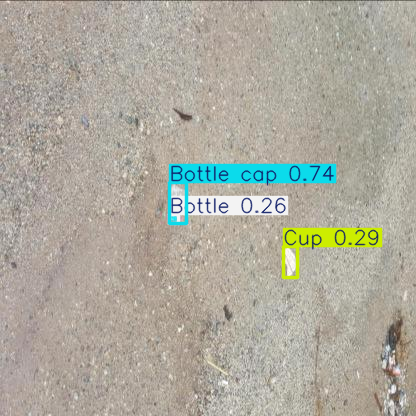

In [12]:
# ✅ Step 1 — Install/Upgrade YOLOv8
!pip install ultralytics --upgrade

# ✅ Step 2 — Import Libraries
from ultralytics import YOLO
import os

# ✅ Step 3 — Paths
DATA_YAML = "/content/dataset/data.yaml"  # aapka data.yaml path
PROJECT_NAME = "waste_detection"
EXPERIMENT_NAME = "exp_balanced_nano"

# ✅ Step 4 — Load YOLOv8 Nano
model = YOLO("yolov8n.pt")  # Nano model: lightweight, fast, CPU friendly

# ✅ Step 5 — Train the model
model.train(
    data=DATA_YAML,
    epochs=100,            # CPU/GPU limit ke hisaab se adjust karein
    imgsz=416,            # Image size: small objects detection ke liye
    batch=8,              # CPU pe slower → reduce, GPU pe increase (16+)
    project=PROJECT_NAME,
    name=EXPERIMENT_NAME,
    augment=True,         # Built-in augmentations
    mosaic=0.5,           # Mosaic augmentation
    mixup=0.2,            # Mixup augmentation
    copy_paste=0.1,       # Copy-Paste augmentation
    hsv_h=0.015,          # Hue augmentation
    hsv_s=0.7,            # Saturation augmentation
    hsv_v=0.4,            # Value/Brightness augmentation
    flipud=0.3,           # Vertical flip
    lr0=0.001,            # Initial learning rate
    patience=20,          # Early stopping patience
    save_period=5,        # Model save every 5 epochs
    workers=2             # CPU cores for data loading
)

# ✅ Step 6 — Validate on validation set
results = model.val()  # Prints precision, recall, mAP
print("Validation results:", results)

# ✅ Step 7 — Predict / Test on new images
TEST_IMAGES = "/content/dataset/test/images"  # test images folder
predictions = model.predict(TEST_IMAGES, save=True, conf=0.25, iou=0.45)
print("Predicted images saved to folder:", "/content/runs/detect/predict")

# ✅ Step 8 — Visualize first prediction
predictions[0].show()


In [21]:
# 1️⃣ Install ultralytics if not already
!pip install ultralytics --upgrade

from ultralytics import YOLO
import os

# 2️⃣ Path to already saved weights in Colab
weights_path = "/content/best.pt"  # <-- change if a different path

# 3️⃣ Load model
model = YOLO(weights_path)

# 4️⃣ Folder containing new images
INFER_FOLDER = "/content/new_images"  # Make sure this folder exists
os.makedirs(INFER_FOLDER, exist_ok=True)

# 5️⃣ Inference
results = model.predict(source=INFER_FOLDER, save=True, conf=0.25, iou=0.45)

# 6️⃣ Location of predictions
print("Predicted images saved at:", "/content/runs/detect/predict")

# 7️⃣ Show first result
results[0].show()


FileNotFoundError: [Errno 2] No such file or directory: '/content/best.pt'

Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,009,158 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 606.2±284.7 MB/s, size: 26.8 KB)
val: Scanning /content/dataset/valid/labels.cache... 1704 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1704/1704 2.6Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 107/107 8.4it/s 12.7s
                   all       1704       4830      0.588      0.297      0.332      0.259
        Aluminium foil         48         62      0.859      0.435      0.486      0.389
            Bottle cap        347        459      0.647      0.571      0.589      0.452
                Bottle        275        320      0.722      0.291      0.436      0.292
          Broken glass         13        123        0.1     0.0163     0.0186      0.014
                   Can        187        267 

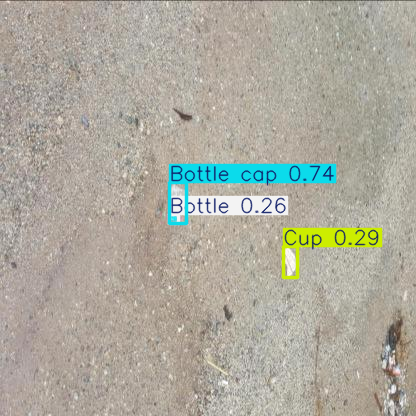

In [22]:
# 1️⃣ Import and load model
from ultralytics import YOLO

# Load your trained weights (best.pt or last.pt)
model = YOLO("/content/waste_detection/exp_balanced_nano/weights/best.pt") # Corrected path

# 2️⃣ Evaluate on validation set
val_results = model.val(data="/content/dataset/data.yaml")  # Corrected: use data.yaml
print("\n✅ Validation Metrics:")
print(val_results)

# 3️⃣ Run inference on test images
test_results = model.predict("/content/dataset/test/images", save=True, conf=0.25, iou=0.45)
print("\n✅ Test images predictions saved at: /content/runs/detect/predict")

# 4️⃣ Visualize first prediction
test_results[0].show()

In [16]:
from ultralytics import YOLO
import os

# 1️⃣ Load your trained model
model = YOLO("/content/waste_detection/exp_balanced_nano/weights/best.pt")  # ya last.pt

# 2️⃣ Folder jahan images hain
image_folder = "/content/dataset/test/images"  # yahan aap apni new images ka path den

# 3️⃣ Make sure output folder exists
output_folder = "/content/runs/detect/predict"
os.makedirs(output_folder, exist_ok=True)

# 4️⃣ Predict on all images in folder
for img_file in os.listdir(image_folder):
    if img_file.lower().endswith((".jpg", ".png", ".jpeg")):
        img_path = os.path.join(image_folder, img_file)
        results = model.predict(img_path, save=True, project=output_folder, name="results", conf=0.25, iou=0.45)
        # Display first prediction for each image
        results[0].show()

Output hidden; open in https://colab.research.google.com to view.